In [2]:
import numpy as np
import librosa
from scipy.io.wavfile import read, write
from matplotlib import pyplot as plt
import scipy.ndimage
import IPython.display as display

/var/folders/67/tfnxn66j4336wyzh50db4620rz9tqp/T/ipykernel_47242/2938345504.py:2: WavFileWarning: Reached EOF prematurely; finished at 79244 bytes, expected 4294967295 bytes from header.
  rate, audio = read('/Users/17756350/Downloads/sample.wav')


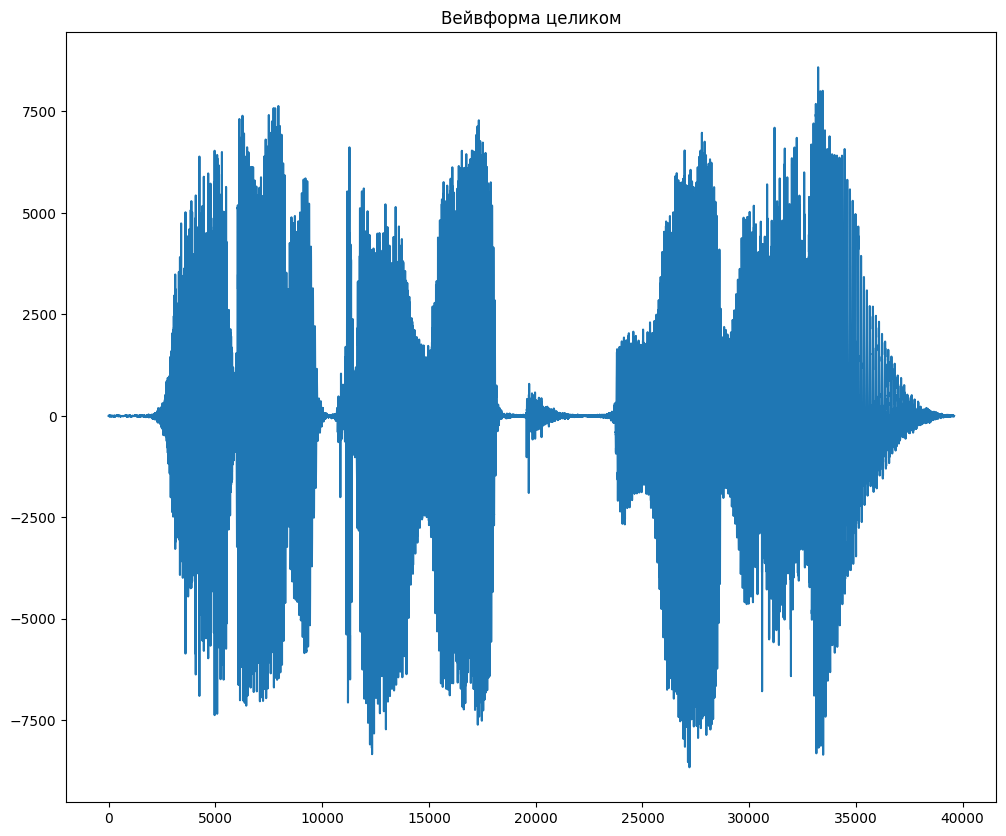

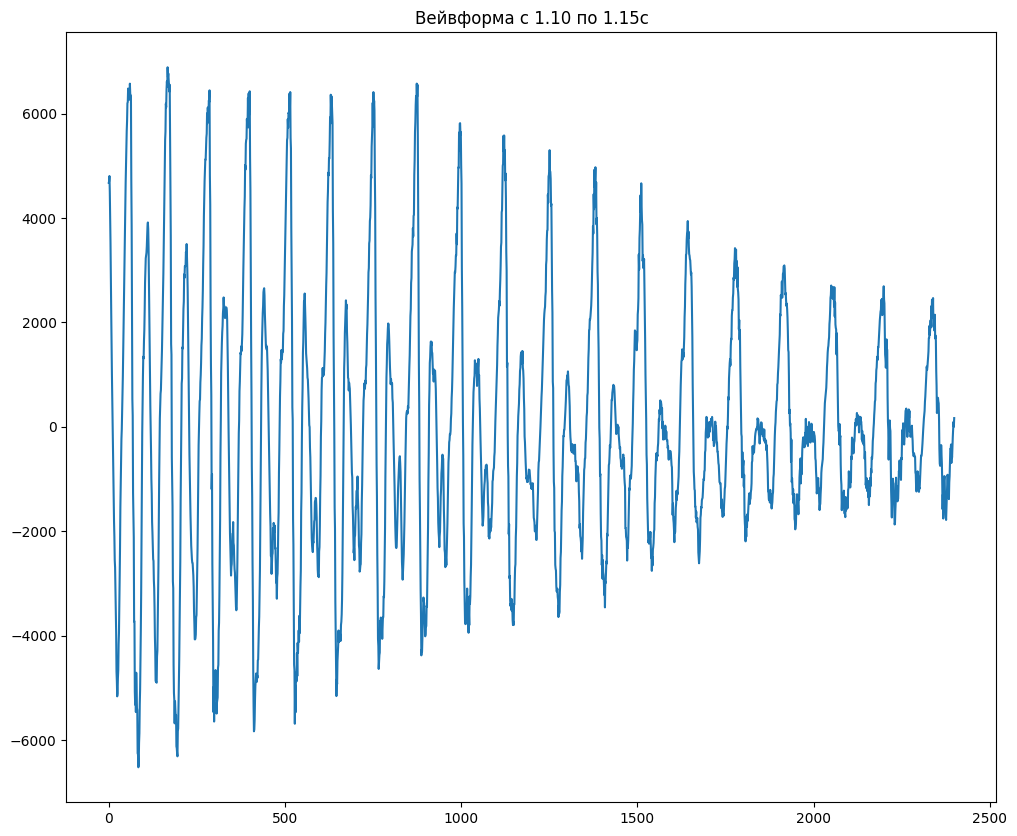

In [4]:
# audio, rate = librosa.load('/Users/17756350/Downloads/sample.wav')
rate, audio = read('/Users/17756350/Downloads/sample.wav')
# 24000
plt.figure(figsize=(12, 10))
plt.title('Вейвформа целиком')
plt.plot(audio)

plt.figure(figsize=(12, 10))
plt.title('Вейвформа с 1.10 по 1.15с')
plt.plot(audio[int(rate*1.4):int(rate*1.5)])


Изучаем частоту Найквиста

In [5]:
print(rate)

def resample(audio, scale=2):
    subscaled = audio[::scale]
    return scipy.ndimage.zoom(subscaled, scale)

24000


In [6]:
audio_12khz = resample(audio, 2)
audio_6000hz = resample(audio, 4)
audio_3000hz = resample(audio, 8)
audio_1500hz = resample(audio, 16)
audio_375hz = resample(audio, 64)


In [12]:
display.Audio(audio_375hz, rate=rate)

Time-frequency domain

(39600,)
(1025, 78)
[[-1.12414932e-03+0.00000000e+00j -3.31655192e-03+0.00000000e+00j
  -5.66684825e-03+0.00000000e+00j ... -4.04058937e-02+0.00000000e+00j
   4.08349564e-03+0.00000000e+00j  1.43803972e-02+0.00000000e+00j]
 [ 1.24721571e-03-9.60015614e-05j  1.14735488e-03-2.38473466e-03j
  -4.99963556e-04+1.24378119e-03j ...  3.57530384e-02+2.91471938e-02j
  -1.62468835e-02+1.44003053e-02j -8.60542338e-03-6.51482793e-03j]
 [-3.18931666e-03+1.24855440e-03j  5.76492923e-03+3.87339863e-03j
  -3.69614172e-03-1.32620918e-02j ... -2.00051723e-02-3.71285575e-02j
   1.17069611e-02+4.96385300e-03j  3.21647615e-03+6.81851389e-04j]
 ...
 [ 4.61485920e-04+9.63797388e-04j -9.02099714e-04-4.93991636e-04j
   9.12751715e-04-8.90148006e-04j ...  1.90665995e-03-3.02938280e-03j
  -2.29803001e-03+1.28476918e-03j -2.46055805e-04-8.03565506e-04j]
 [-8.40176951e-04-5.82434563e-04j -6.74213629e-04+2.82886802e-04j
  -3.78835837e-04+9.07763787e-04j ... -4.96508072e-03+5.96747047e-03j
   1.28615772e-03+2.0258415

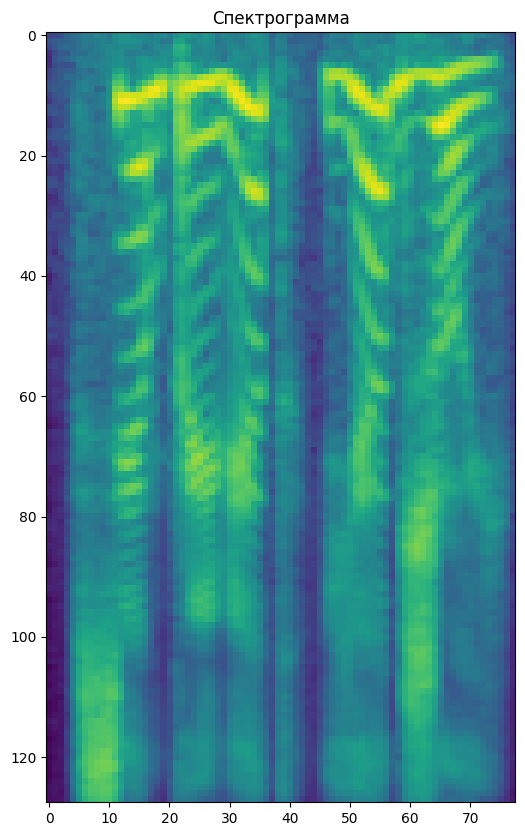

In [21]:
print(audio.shape)
stft = librosa.core.stft(audio / 2**15)  # audio samples in [-1, 1]
print(stft.shape)
print(stft)
print(stft.shape[0] * stft.shape[1])

spectrogram = np.abs(stft)
phase = np.angle(stft)
print(spectrogram.shape, phase.shape)

plt.figure(figsize=(40, 10))
plt.title('Спектрограмма')
plt.imshow(np.log(1.e-8 + spectrogram)[::-1])  # логарифм для красоты
plt.imshow(np.log(1.e-8 + librosa.feature.melspectrogram(y=audio / 2**15)))
# plt.imshow(phase)

# plt.figure(figsize=(12, 10))
# plt.title('Фаза')
# plt.imshow(phase)

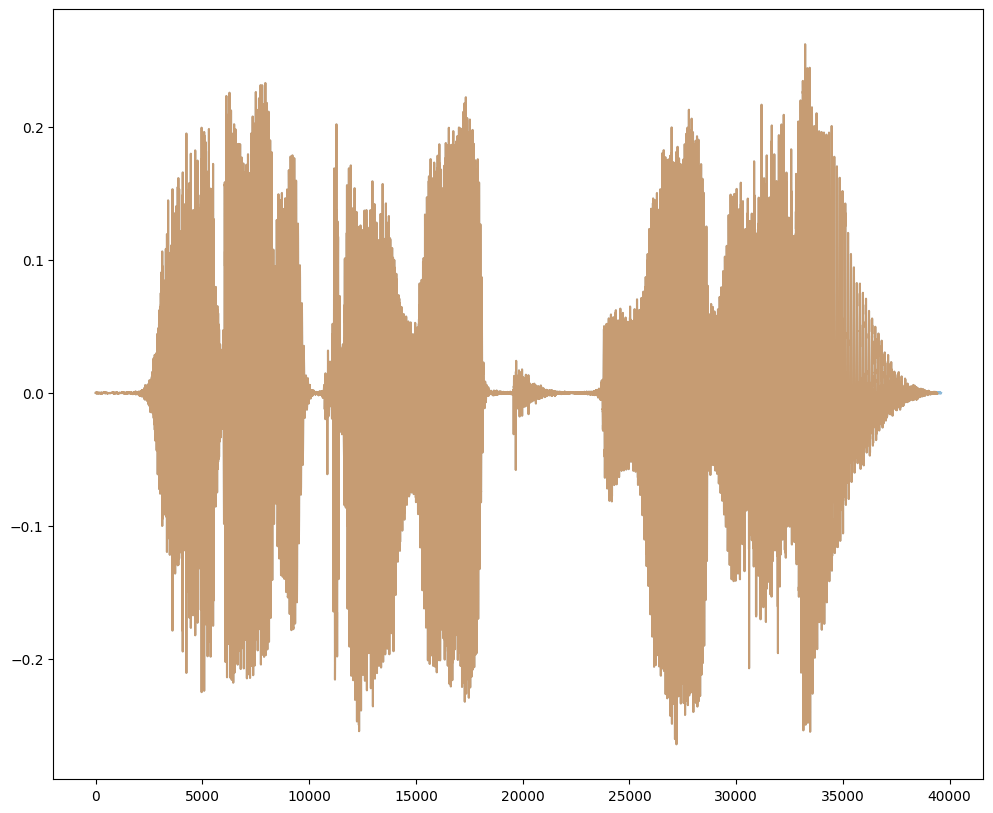

In [25]:
restored_audio = librosa.core.istft(spectrogram * np.exp(1j * phase))

plt.figure(figsize=(12,10))
plt.plot(audio / 2**15, alpha=0.5)
plt.plot(restored_audio, alpha=0.5)

Пробуем алгоритм pitch-shift

In [26]:
def pitch_shift(audio, scale):
    freq_bins = spectrogram.shape[0]
    num_frames = spectrogram.shape[1]
    log_spectrogram = np.log(1.e-8 + spectrogram)
    
    if scale < 1:
        shifted_spectrogram = scipy.ndimage.zoom(log_spectrogram[:int(freq_bins * scale)], (1./scale, 1))
        shifted_phase = scipy.ndimage.zoom(phase[:int(freq_bins * scale)], (1./scale, 1))
    else:
        shifted_spectrogram = scipy.ndimage.zoom(log_spectrogram, (1./scale, 1))
        shifted_phase = scipy.ndimage.zoom(phase, (1./scale, 1))
        # матрицы уменьшились, нужно дополнить их нулями
        shifted_spectrogram = np.vstack((shifted_spectrogram, np.log(1.e-8) + np.zeros((freq_bins - shifted_spectrogram.shape[0], num_frames))))
        shifted_phase = np.vstack((shifted_phase, np.zeros((freq_bins - shifted_phase.shape[0], num_frames))))

    return np.exp(shifted_spectrogram), shifted_phase
    

(1025, 78) (1025, 78)


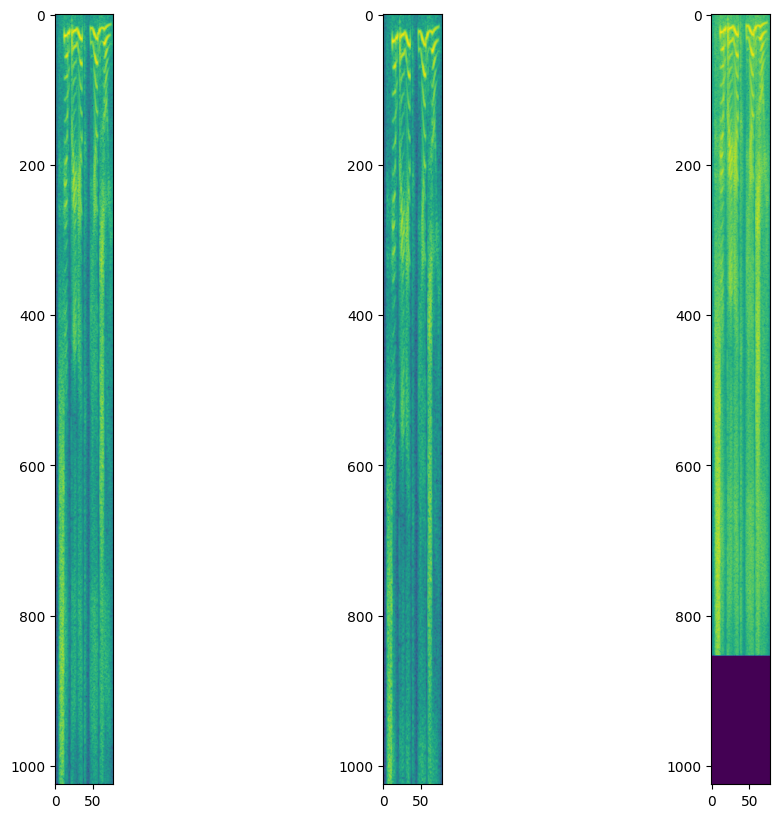

In [27]:
lower_spectrogram, lower_phase = pitch_shift(audio, 0.8)
higher_spectrogram, higher_phase = pitch_shift(audio, 1.2)

log_spectrogram = np.log(1.e-8 + spectrogram)

print(lower_spectrogram.shape, higher_spectrogram.shape)
plt.figure(figsize=(12, 10))
plt.subplot(131)
plt.imshow(log_spectrogram)
plt.subplot(132)
plt.imshow(np.log(lower_spectrogram))
plt.subplot(133)
plt.imshow(np.log(higher_spectrogram))



In [31]:
lower_audio = librosa.core.istft(lower_spectrogram * np.exp(1j * lower_phase))
higher_audio = librosa.core.istft(higher_spectrogram * np.exp(1j * higher_phase))

display.Audio(lower_audio, rate=rate)

In [ ]:
display.Audio(lower_audio, rate=rate)

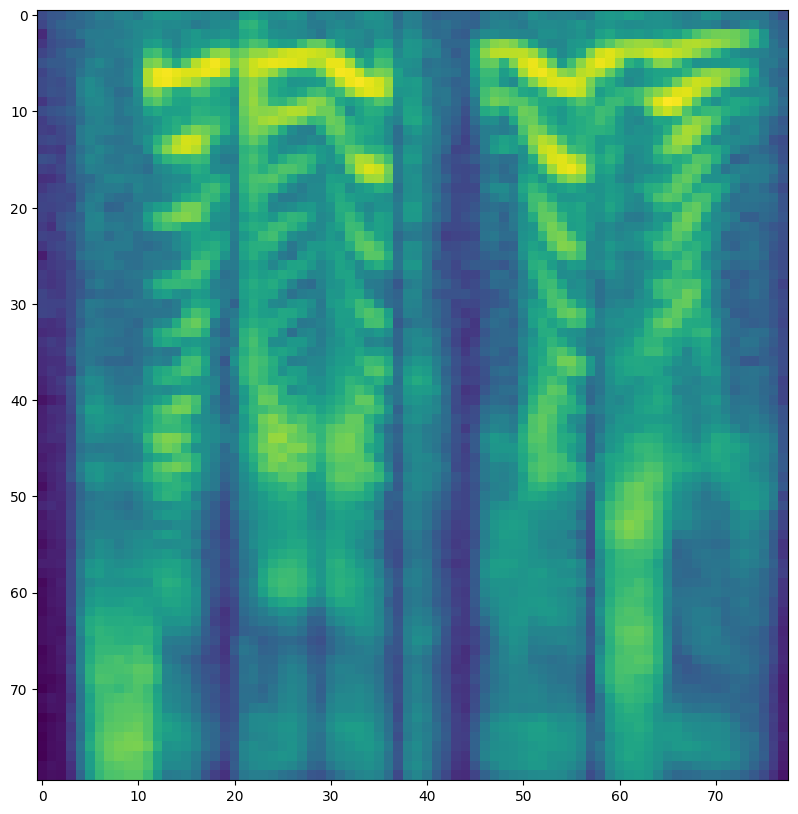

In [34]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio / 2**15, n_mels=80)
plt.figure(figsize=(12, 10))
plt.imshow(np.log(1.e-8 + mel_spectrogram))

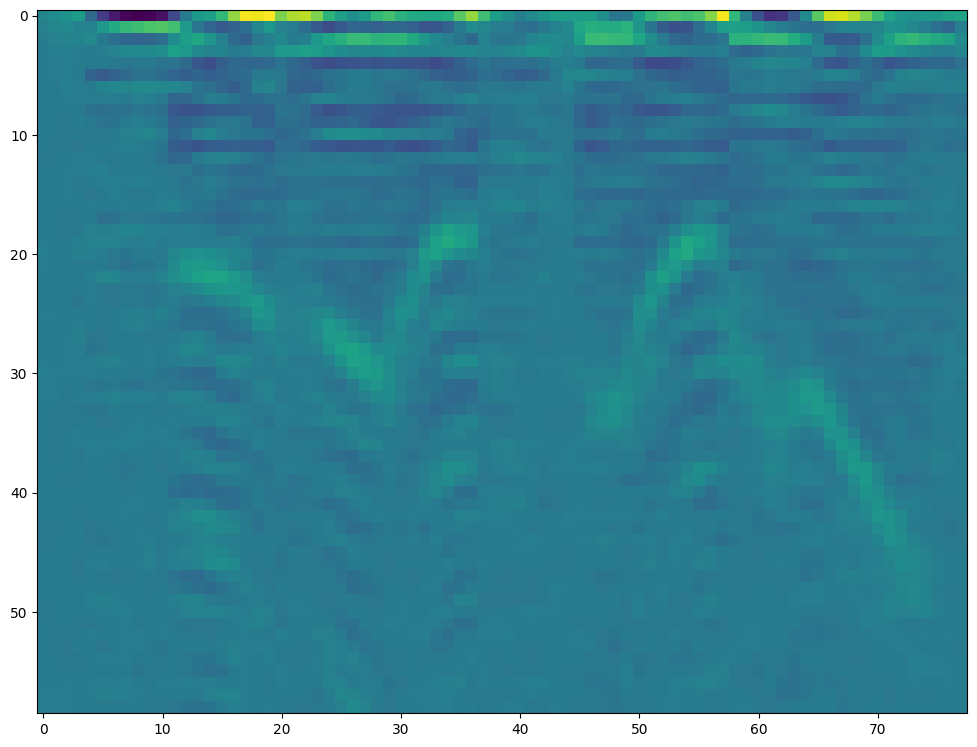

In [43]:
mfcc = librosa.feature.mfcc(y=audio / 2**15, n_mfcc=60)
plt.figure(figsize=(12, 10))
plt.imshow(mfcc[1:])